# Кредитный скоринг

В задаче кредитного скоринга чаще всего применяется логистическа регрессия, как алгоритм извлечения зависимости.  
Из-за линейности модели важным является отбор и преобразования признаков.  
В данном ноутбуке мы рассмотрим несколько подходов к преобразования признаков.

---
# Загружаем выборку с данными

Выборка содержит заявки на кредит и поля:
* `application_date` - дата обработки заявки
* `default_flg` - факт наличия дефолта
* `f*, v*, d*` - признаки заявки

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

url_data = 'https://www.dropbox.com/s/vs9daqt83j8kfqf/feature_transformation.csv?dl=1'
df = pd.read_csv(url_data, parse_dates=['application_date'])
df.head()

,default_flg,application_date,f1,f2,f3,f4,v1,v2,v3,d1,d2
0,0,2015-10-27,2.0,49.0,60000.00,0.551720,1219.487337,21766.081065,2.0,0.047946,0.000000
1,1,2015-11-09,2.0,50.0,59365.20,0.379425,740.270898,11276.991322,2.0,-0.210390,0.377392
2,0,2015-05-07,2.0,18.0,43764.35,-0.260096,539.627752,11974.353651,0.0,-0.176838,0.426828
3,0,2015-11-15,2.0,60.0,60000.00,-0.522040,1046.368464,11772.704811,2.0,-0.213644,0.340425
4,0,2015-03-16,2.0,18.0,41637.74,0.179889,786.084579,14096.999560,2.0,-0.230048,0.472925


Мы будем извлекать зависимость между признаками и целевой переменной.   
Для валидации модели необходимо разбить выборку на две части по дате обработки заявки:
* обучающая выборка - заявки с датой подачи заявки ранее '2015-08-01'
* тестовая выборка - заявки с датой подачи начиная с '2015-08-01'

**Задание 1. Разбейте выборку на две части и посчитайте количество объектов в каждой выборке**

In [3]:
features = ['f1','f2','f3','f4','v1','v2', 'v3','d1', 'd2']

X = df[features]
X_train = df.query('application_date <= "2015-08-01"')[features]
X_test = df.query('application_date > "2015-08-01"')[features]

y_train = df.query('application_date <= "2015-08-01"')['default_flg']
y_test = df.query('application_date > "2015-08-01"')['default_flg']

assert len(X_train) == len(y_train) and len(X_test) == len(y_test)
print('Обучающая выборка: ', len(X_train))
print('Тестовая выборка : ', len(X_test))

Обучающая выборка:  29924
Тестовая выборка :  20076


---
# Подбор коэффициента регуляризации для логистической регресии

Для извлечения зависимости будем использовать [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) с l2 регуляризацией.  

**Задание 2.**  
    Переберите коэффициент регуляризации в интервале от $10^{-3}$ до $10^{3}$.  
    Постройте график зависимости качества AUC на тестовой выборке от коэфиициента регуляризации и найдите оптимальное значение.

In [14]:
import tqdm
from tqdm import tqdm

100%|██████████| 10000/10000 [37:35<00:00,  4.43it/s]


AUC    0.61572
dtype: float64
Best C:  884.501


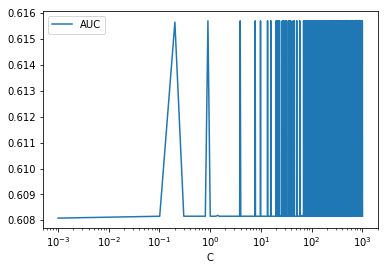

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))

for C in tqdm(np.arange(0.001, 1000.0, 0.1)):  # <изменить диапазон подбора коэффициента C>
    clf = LogisticRegression(C=C)   
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    metrics.loc[C] = auc
print(metrics.max())
C_best = metrics.AUC.idxmax()
print('Best C: ', C_best)
metrics.plot(logx=True);

In [30]:
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

def add_metrics(metrics, target, predict, name):
    # для обращения к ячейкам есть метод .loc[название строки, название столбца]
    metrics.loc[name, 'MSE'     ] = mean_squared_error (target, predict)
    metrics.loc[name, 'AUC'     ] = roc_auc_score      (target, predict)
    metrics.loc[name, 'log_loss'] = log_loss           (target, predict)

In [141]:
metrics = pd.DataFrame()

clf = LogisticRegression(C=C_best)   
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
add_metrics(metrics, y_test, y_pred, 'base')
metrics

,MSE,AUC,log_loss
base,0.112766,0.608159,0.383905


---
# Нормализация признаков

Так как l2 регуляризация одинакого штрафует все признаки, то имеет смысл нормировать их все таким образом, чтобы стандартное отклонение равнялось 1 у всех признаков. Для этого можно воспользоваться [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Нормализовывать признаки стоит исходя из обучающей выборки, чтобы избегать переобучения.  
Для удобства трансформирования выборки В scikit-learn есть объекты [transformation](http://scikit-learn.org/stable/data_transforms.html), которые только преобразуют наборы признаков.  

Так же есть возможность объединять трансформации и модель в единый [пайплайн](http://scikit-learn.org/stable/modules/pipeline.html)
```python
classificator = make_pipeline(
    transformator_1,
  ...
    transformator_2,
    classifier
)
```

При обучении будут подряд обучаться и применятся трансформаторы transformator_1 ... transformator_k, а затем на полученных признаках обучаться модель.  
Данный подход удобен тем, что позволяет не изменять исходные выборки признаков и избежать ошибки с дублированием преобразований для обучающей и тестовой выборках.


**Задание 3.**  

  Произведите нормализацию признаков и опять подберите коэфиициент C.  
  Каким образом изменилось качество на тестовой выборке?  
  Запомните лучшее значение коэффициента регуляризации и затем используйте его.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

100%|██████████| 10000/10000 [15:37<00:00, 10.67it/s]


AUC    0.700604
dtype: float64
Best C:  169.60100000000003


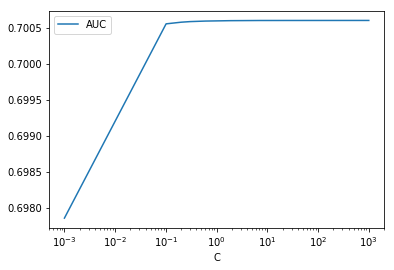

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

metrics_scaled = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))

for C in tqdm(np.arange(0.001, 1000.0, 0.1)):  # <изменить диапазон подбора коэффициента C>
    clf = LogisticRegression(C=C)   
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    metrics_scaled.loc[C] = auc
print(metrics_scaled.max())
C_best = metrics_scaled.AUC.idxmax()
print('Best C: ', C_best)
metrics_scaled.plot(logx=True);

In [142]:
clf = LogisticRegression(C=C_best)   
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict_proba(X_test_scaled)[:, 1]
add_metrics(metrics, y_test, y_pred, 'scaled')
metrics

,MSE,AUC,log_loss
base,0.112766,0.608159,0.383905
scaled,0.104434,0.700604,0.355366


---
# Нормализация WoE

Влияние некоторых признаков на целевую переменную может быть нелинейным с точки зрения WoE.  
Поэтому имеет смысл преобразовать признаки таким образом, чтобы зависимость стала линейной.

**Задание 4.**  
  Преобразуйте часть признаков таким образом, чтобы график зависимости WoE стал более линейным.  
  Посчитайте качество логистической регрессии после такой нормализации.

In [42]:
from scipy.special import logit

def woe_line(feature, target, num_bucket=10):
    """Подсчет зависимости WoE от среднего значения признака в бакете"""
    
    data = pd.DataFrame({'target': target, 'feature': feature})
    data['bucket'] = pd.qcut(feature, q=num_bucket, duplicates='drop')
    data['obj_count'] = 1
    
    target_mean = data['target'].mean()
    total_count = data['obj_count'].sum()
    
    data_agg = data.groupby('bucket').agg({'target': 'mean', 'feature': 'mean', 'obj_count': 'sum'})
    
    data_agg['target'] = np.clip(data_agg['target'], 0.001, 0.999)
    data_agg['woe'] = logit(data_agg['target']) - logit(target_mean)
    
    return data_agg[['feature', 'woe']]

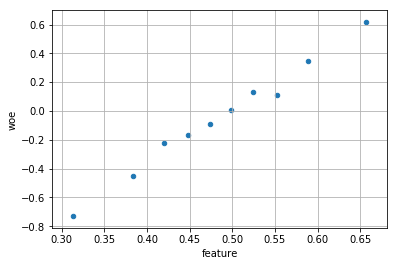

In [115]:
# Пример рисования зависимости woe от значений признака exp(f4)
woe_line(X_train['d2'], y_train).plot(kind='scatter', x='feature', y='woe', grid=True);

In [144]:
from sklearn.preprocessing import FunctionTransformer


def feature_modification(X):
    """Функция модифицирования признаков"""
    X = pd.DataFrame(X, columns=X_train.columns).copy()
    X['v1'] = np.log(X['v1'])
    X['v2'] = np.log(X['v2'])
    return X

clf = make_pipeline(
    FunctionTransformer(feature_modification),
    StandardScaler(),
    LogisticRegression(C=C_best)
)
    
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
add_metrics(metrics, y_test, y_pred, 'scaled_WoE')
print(auc)

0.7094416282837188


In [145]:
metrics

,MSE,AUC,log_loss
base,0.112766,0.608159,0.383905
scaled,0.104434,0.700604,0.355366
scaled_WoE,0.103694,0.709442,0.352515


---
# Стабильность признаков

Так как мы используем валидацию по времени, то некоторые признаки могут оказаться нестабильными и сильно изменять свое распределение.  
Иногда исключение данных признаков из обучения положительно сказывается на качестве модели на отложенной выборке.

**Задание 5.**  
  Произвести анализ стабильности распределений признаков по времени. Попытаться выделить нестабильные признаки.  
  Посчитать качество модели с исключенными нестабильными признаки.

In [123]:
def plot_distribution_stability(feature, date, num_buck=10, date_freq='M'):
    """Рисуем изменение распределения признака по времени"""
    df = pd.DataFrame({'feature': feature, 'date': date})
    df['feature_buck'] = pd.qcut(feature, q=num_buck, duplicates='drop')
    df_agg = df.groupby([pd.Grouper(key='date', freq=date_freq), 'feature_buck']).size().unstack()
    df_agg = df_agg.apply(lambda x: x / df_agg.sum(axis=1))
    df_agg.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1, 1))

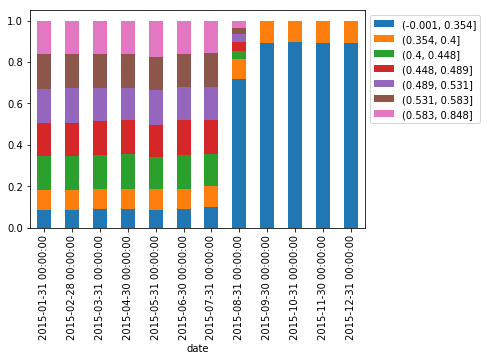

In [137]:
# Пример рисования изменения распределения у признака 'f1'
plot_distribution_stability(df['d2'], df['application_date'])

In [146]:
def drop_features(X):
    """Функция отбрасывания части признаков"""
    X = pd.DataFrame(X, columns=X_train.columns)
    X = X.drop(columns=['d1', 'd2'])  # пример с отбрасыванием признака f1
    return X


clf = make_pipeline(
    FunctionTransformer(feature_modification),
    FunctionTransformer(drop_features),
    StandardScaler(),
    LogisticRegression(C=C_best),
)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
add_metrics(metrics, y_test, y_pred, 'scaled_WoE_stabilized')
print(auc)

0.7340043372671532


In [147]:
metrics

,MSE,AUC,log_loss
base,0.112766,0.608159,0.383905
scaled,0.104434,0.700604,0.355366
scaled_WoE,0.103694,0.709442,0.352515
scaled_WoE_stabilized,0.102404,0.734004,0.344841


---
# Вывод

**Задание 6.**  
  Сравните результаты преобразования и отборов признаков по качеству. Какие методы и почему дали прирост в качестве?  
  Какие из них можно автоматизировать и каким образом? (В этом задании нужно только написать текст).

Были проведены:
    - нормализация признаков (приведение стандартного отклонения у всех признаков к 1)
    - логарифмирование признаков v1 и v2 с целью приведения зависимости между ними и целевой переменной к более    
        линейному виду
    - отбор стабильных признаков

Каждая операция предобработки признаков улучшала качество: средняя квадратичная ошибка и log loss в итоге уменьшаются на 0.01 и 0,04 соответственно, аук в итоге увеличивается на 0.13. 

Нормализация признаков проводится автоматически с помощью функции StandardScaler().

Чтобы привести зависимость между признаком i и целевой переменной y к более линейному виду, можно автоматически применять последовательно все функции f из списка стандартных функций (экспонента, логарифм, др.) к i и сравнивать зависимость между f(i) и y с линейной функцией (например, пробовать предсказать полученную зависимость с помощью линейной регрессии и оценивать качество).

Проверять признак на стабильность можно какими-нибудь статистическими тестами: насколько количество значений из определенного квантиля отличается от среднего по всем количествам этих значений во всех временных промежутках.